# Build Data Extraction & Preprocessing Pipeline

## Define Transcription Extraction Approach & Storage Functions

In [7]:
import os, re
import tempfile
import subprocess
import whisper
from unidecode import unidecode
from youtube_transcript_api import YouTubeTranscriptApi
from src._check_retrieve_transcript import *

from dotenv import load_dotenv
load_dotenv()


def get_video_title(youtube_url):
    try:
        result = subprocess.run(
            ["yt-dlp", "--get-title", youtube_url],
            capture_output=True, text=True, check=True, encoding="utf-8"
        )
        title = result.stdout.strip()
        return title
    except subprocess.CalledProcessError:
        return "transcription"

def sanitize_title(title):
    title = unidecode(title)
    sanitized = re.sub(r'[^\w\s\-]', '', title)
    sanitized = sanitized.lower().strip().replace(' ', '_')
    return sanitized

def extract_yt_direct(youtube_url):
    try:
        url = youtube_url
        video_id = re.search(r'.+?v=(.*)',url)[1]
        trans = YouTubeTranscriptApi.get_transcript(video_id)
        list_trans = []

        for chunk in trans:
            list_trans.append(chunk.get("text"))

        trans_fin = " ".join(list_trans).replace("xa0","")
        trans_fin_san = re.sub(r'[^\w\s\-]', '', trans_fin)
        trans_fin_san = re.sub(r'\s+', ' ', trans_fin_san)
        return trans_fin_san
    except Exception as e:
        return "error"

def extract_transcription(url=None):
    """
    function to extract transcription:
        1. First get the title of the video
        2. Check if transcript already in place (on github directory as a database)
        3. If not, extract transcript directly online
        4. If not, extract audio & transcribe
        5. Export to github

    Args:
        url (str, optional): _description_. Defaults to None.

    Returns:
        transcription
        title
    """
    if url != None:
        youtube_url = url
    else:
        youtube_url = str(input("Enter a youtube url: "))
    
    # Get video title
    title = sanitize_title(get_video_title(youtube_url))
    title = title if len(title) < 38 else title[:38]

    # Check if transcript already in place
    check_trans = check_retrieve_transcript_db(title)
    if check_trans == "File not found" or len(check_trans)==0:
        # Case 1: Can extract transcript directly online
        transcription = extract_yt_direct(youtube_url=youtube_url)
        if "error" not in transcription and len(transcription) != 0:
            export_to_github(title, transcription)
            return transcription,title

        # Case 2: Extract audio & transcribe
        else:
            with tempfile.TemporaryDirectory() as temp_dir:
                audio_file_path = os.path.join(temp_dir, "audio.mp3")
                
                # Download only audio using yt-dlp
                subprocess.run([
                    "yt-dlp",
                    "--extract-audio",
                    "--audio-format", "mp3",
                    "--output", audio_file_path,
                    "--ffmpeg-location", r"C:\Users\ACER\Downloads\ffmpeg-master-latest-win64-gpl\bin",
                    youtube_url
                ], check=True)

                print("Downloaded file path:", audio_file_path)
                print("Exists?", os.path.isfile(audio_file_path))

                os.environ["PATH"] += os.pathsep + r"C:\Users\ACER\Downloads\ffmpeg-master-latest-win64-gpl\bin"
                print("PATH:", os.environ["PATH"])
                
                # Load Openai Whisper model
                """remember to install cuda version that matches your gpu: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118"""
                whisper_model = whisper.load_model("base", device="cuda")           
                print("Model device:", whisper_model.device)
                
                # Transcribe
                cur_transcription = whisper_model.transcribe(audio_file_path, fp16=True)["text"].strip()

                export_to_github(title, cur_transcription)

                return cur_transcription,title
    else:
        return check_trans.lower(),title

## Define Data Cleaning Functions

In [8]:
import re

def text_cleaner(text):
    """Remove redundant characters that are not alphanumeric

    Args:
        text (str): input text
    """
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, ' ', text).strip()
    text = re.sub(r'\s+', ' ', text)
    return text

# Remove stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def remove_stopwords(text):
    """Remove stopwords

    Args:
        text (str): input text

    Returns:
        text (str): cleaned text without stopwords
    """
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [9]:
# %%time

# nltk.download('punkt_tab')

## Define Data Preprocessing & Storage Functions

### Split Documents

In [10]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from langchain_community.document_loaders import TextLoader
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_document(transcription):
    text = transcription
    text_documents = [Document(page_content=text)]
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=50)
    documents = text_splitter.split_documents(text_documents)
    return documents

### Set up Embedding Model, Pine Cone DB & Store Vectors

In [11]:
from pinecone import Pinecone

pc = Pinecone(
    api_key=os.getenv("PINECONE_API_KEY")
)

from langchain_openai.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

def store_vector_db(title,documents):
    title = title.replace("_","-")
    index_name = f"{title}-index"
    if index_name not in str(pc.list_indexes()):
        pc.create_index(index_name,dimension = 1536, metric = "cosine", 
                        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
                        deletion_protection="disabled")
        index = pc.Index(host = pc.describe_index(index_name).host)
        pinecone = PineconeVectorStore.from_documents(documents=documents, embedding=embeddings, index_name=index_name
    )
        return pinecone
    else:
        index = pc.Index(host = pc.describe_index(index_name).host)
        pinecone = PineconeVectorStore(index=index, embedding=embeddings)
        return pinecone

def reset_index(title):
    index_name = f"{title}-index"
    index = pc.Index(host= pc.describe_index(index_name).host)
    index.delete_index(delete_all=True)

## Constructing Pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class ExtractVideoTranscription(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transcription, title = extract_transcription(X)
        return {"transcription": transcription, "title": title}

class CleanTranscription(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        trans = remove_stopwords(text_cleaner(X["transcription"]))
        return {"transcription": trans, "title": X["title"]}

class SplitDocuments(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        documents = split_document(X["transcription"])
        return {"documents": documents, "title": X["title"]}

class StoreVectorDB(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        title = X["title"]
        documents = X["documents"]
        store_vector_db(title,documents)
        return {"documents": documents, "title": title}

# Perform Data Extraction & Preprocessing

In [13]:
preprocessing_pipeline = Pipeline([
    ("extract", ExtractVideoTranscription()),
    ("clean", CleanTranscription()),
    ("split", SplitDocuments()),
    ("store", StoreVectorDB()),
])

preprocessed_dict = preprocessing_pipeline.fit_transform(str(input("Enter a youtube url: ")))
documents, title = preprocessed_dict.values()

Searching for file data_trans/jensen_huang_--_nvidias_ceo_on_the_nex.txt...
200
Found file. Downloading...


# Agent 1: Context-Based Querying Assistant

In [16]:
from langchain_openai.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda
from langchain.memory import ConversationBufferMemory
from deep_translator import GoogleTranslator
from langdetect import detect
from langchain_community.tools.tavily_search import TavilySearchResults
import warnings
warnings.filterwarnings("ignore")

model = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model_name="gpt-4o-mini"
)
memory = ConversationBufferMemory(return_messages=True)

parser = StrOutputParser()
translator = GoogleTranslator(source="vi", target="en")

"""-----------------------------------------------------------------"""
# define an query rewriting agent for current query + most recent chat history
def retrieve_history(k=3):
    k = k*2
    history = memory.load_memory_variables({}).get("history")[-k:]
    pattern = r"^(content=')(.*?)(' .*?)$"
    a=1
    b=0
    cleaned_dict={}
    for idx,i in enumerate(history):
        output = re.sub(pattern=pattern,string=str(i),repl=r"\2")
        name = "Human" if idx%2==0 else "AI"
        question_no = a
        b+=1
        if b >= 2:
            b=0
            a+=1
        if b==1:
            cleaned_dict[f'Question {question_no}'] = {}
        cleaned_dict[f'Question {question_no}'][name] = output
    return cleaned_dict

def rewrite_query(new_query):
    current_hist = retrieve_history()
    history = str(current_hist)
    rewrite_prompt = [
        SystemMessage(content="You are a helpful query rewriting assistant. Rewrite the user's query based on their recent history. Return only the rewritten query."),
        HumanMessage(content=f"History: {history}\nNew query: {new_query}")
    ]
    outcome = model.invoke(rewrite_prompt).content # may modify using a nicher model
    print(f"Rewritten Query: {outcome}")
    return outcome

"""-----------------------------------------------------------------"""

def retrieve_context(input):
    try:
        # Extract the content from the message object
        if isinstance(input, dict) and "question" in input:
            input = input["question"][-1].content  # Extract human question only
        elif isinstance(input, str):
            input = input  # Directly use the string if provided
        else:
            raise ValueError("Input is not in a valid format.")
    except Exception as e:
        print(f"Error processing input: {e}")
        return None
    
    if detect(input) != "en":
        query = translator.translate(input)
        print(f"Translated query: {query}")
    else:
        query = input
    
    context = store_vector_db(title,documents) \
                .as_retriever(search_type = "similarity_score_threshold",search_kwargs={'score_threshold': 0.5}) \
                .get_relevant_documents(query)
    compiled_docu = " ".join([doc.page_content for doc in context])
    print("Retrieved Context:", compiled_docu, "\n-----\n")
    return compiled_docu

def query_from_context_main():
    template = """
    Think step by step before answering the question based on the context below. If you can't find the answer in the context below, say that you don't know.

    **Context:** {context}

    **Question:** {question}
    """

    prompt = ChatPromptTemplate.from_template(template)
    rewriter = RunnableLambda(rewrite_query)

    retriever_step = RunnableLambda(retrieve_context)
    retriever = RunnableParallel(context = retriever_step,
                        question=RunnablePassthrough(), 
                        #  language = RunnablePassthrough()
                        )
    if memory.load_memory_variables({}).get("history") == []:
        chain = retriever | prompt | model | parser
    else:
        chain = rewriter | retriever | prompt | model | parser
    return chain

"""-----------------------------------------------------------------"""

def web_search_tool(query):
    try:
        query = query["question"][1].content # Extract human question only
    except Exception as e:
        query = query
    web_search_tool = TavilySearchResults(k=3)
    results = web_search_tool.invoke(query)
    extracted_results = "\n".join([remove_stopwords(re.sub(r"[^a-zA-Z0-9\s.,!?]","",res["content"].replace("\n"," ").strip())) for res in results])
    return extracted_results

def alternative_web_search_context(prev_result):
     if "i don't know" in prev_result.lower():
          return True

def build_chain_web():
    rewriter = RunnableLambda(rewrite_query)

    search_step = RunnableLambda(lambda q: web_search_tool(q))  # Search condition
    retriever_web = RunnableParallel(context=search_step, question=RunnablePassthrough())
    web_prompt = ChatPromptTemplate.from_template("Web search-based context:\n{context}\n\n**Question:** {question}")
    if memory.load_memory_variables({}).get("history") == []:
        webchain = retriever_web | web_prompt | model | parser
    else:
        webchain = rewriter | retriever_web | web_prompt | model | parser
    
    return webchain

"""-----------------------------------------------------------------"""


'-----------------------------------------------------------------'

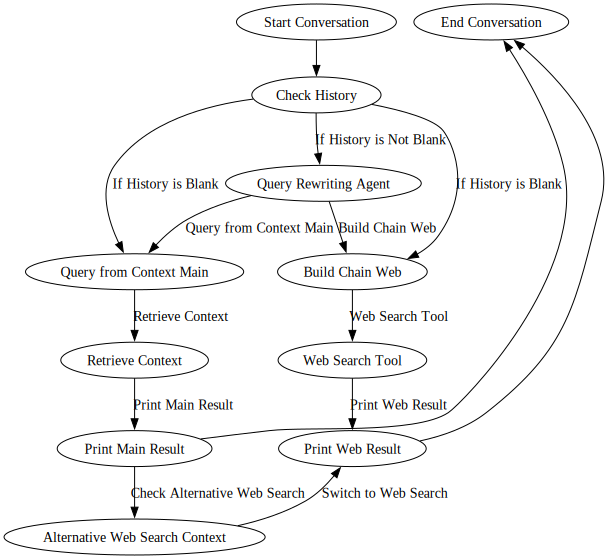

In [17]:
from graphviz import Digraph
from IPython.display import display

def visualize_flow():
    dot = Digraph(comment='Code Flow')

    # Define nodes
    dot.node('A', 'Start Conversation')
    dot.node('B', 'Check History')
    dot.node('C', 'Query from Context Main')
    dot.node('D', 'Build Chain Web')
    dot.node('E', 'Retrieve Context')
    dot.node('F', 'Web Search Tool')
    dot.node('G', 'Alternative Web Search Context')
    dot.node('H', 'Print Main Result')
    dot.node('I', 'Print Web Result')
    dot.node('J', 'End Conversation')
    dot.node('K', 'Query Rewriting Agent')

    # Define edges
    dot.edges(['AB'])
    dot.edge('B', 'C', label='If History is Blank')
    dot.edge('B', 'D', label='If History is Blank')
    dot.edge('B', 'K', label='If History is Not Blank')
    dot.edge('K', 'C', label='Query from Context Main')
    dot.edge('K', 'D', label='Build Chain Web')
    dot.edge('C', 'E', label='Retrieve Context')
    dot.edge('D', 'F', label='Web Search Tool')
    dot.edge('E', 'H', label='Print Main Result')
    dot.edge('F', 'I', label='Print Web Result')
    dot.edge('H', 'G', label='Check Alternative Web Search')
    dot.edge('G', 'I', label='Switch to Web Search', constraint='false')
    dot.edge('H', 'J', constraint='false')
    dot.edge('I', 'J', constraint='false')

    return dot

os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
dot = visualize_flow()
display(dot)

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def start_conversation():
    system_message = SystemMessage(content="You are a truthful expert in extracting insights from provided context for QnA.")
    question_no = 0

    memory.clear()
    print(f"Check history: {memory.load_memory_variables({}).get('history')}")

    input_box = widgets.Text(
        value='',
        placeholder='Type your question here...',
        description='Question:',
        disabled=False
    )

    output_area = widgets.Output()

    def on_submit(change):
        nonlocal question_no
        query = input_box.value.lower()
        input_box.value = ''

        with output_area:
            clear_output(wait=True)
            if query == 'exit':
                print("Goodbye!")
                return

            question_no += 1
            print(f"\nQuestion {question_no}: {query}")

            human_message = HumanMessage(content=query)
            messages = [system_message, human_message]

            chain_main = query_from_context_main()
            main_result = []
            for s in chain_main.stream({"question": messages}):
                main_result.append(s)
                print(s, end="", flush=True)

            if alternative_web_search_context("".join(main_result)):
                feedback = widgets.RadioButtons(
                    options=["Yes", "No"],
                    description="Do you want to switch to web search tool?",
                    disabled=False,
                    value=None  # No default option selected
                )
                def web_demand_change(change):
                    if change.new.lower() == 'yes':
                        print(f"\nSwitching to web search tool...")
                        chain_web = build_chain_web()
                        for s in chain_web.stream({"question": messages}):
                            main_result.append(s)
                            print(s, end="", flush=True)
                    else:
                        print("\nPlease ask a different question.")
                        pass

                feedback.observe(web_demand_change, names='value')
                display(feedback)

            memory.chat_memory.add_user_message(query)  # add user query to memory
            memory.chat_memory.add_ai_message("".join(main_result))  # add ai result to memory
            print("\n", "---" * 20, "\n")

    input_box.on_submit(on_submit)

    display(input_box, output_area)

In [19]:
start_conversation()

Check history: []


Text(value='', description='Question:', placeholder='Type your question here...')

Output()


Switching to web search tool...


12/30/2024 12:56:44 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Rewritten Query: What is the name of Jensen Huang's wife and what is her profession?


12/30/2024 12:56:48 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jensen Huang's wife is Lori Huang, and her profession is a makeup artist based in the UK. Additionally, she serves as the general manager of Mirbeau Inn & Spa in Skaneateles.

# Agent 2: (Advanced) Summarization Assistant

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from textsum.summarize import Summarizer
from langchain.prompts import ChatPromptTemplate
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda
from deep_translator import GoogleTranslator

model_name = "pszemraj/led-large-book-summary"
summarizer = Summarizer(
    model_name_or_path=model_name
)

model = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model_name="gpt-4o-mini"
)

parser = StrOutputParser()
translator = GoogleTranslator(source="vi", target="en")

def fetch_list_pinecone(title) -> pd.DataFrame:
    # Define index
    title_refined = title.replace("_","-")
    index_name = f"{title_refined}-index"

    index = pc.Index(name = index_name, host = pc.describe_index(index_name).host)

    # Define vector_id
    id_list = []
    for id in index.list():
        for i in id:
            id_list.append(i)

    # Fetch vector list including metadata
    fetch_list = index.fetch(ids=id_list)

    # Return df of id, text, vector values
    list_vec = []
    for key, content in fetch_list["vectors"].items():
        id = key
        text = content["metadata"]["text"]
        values = content["values"]
        list_vec.append([id,text,values])
    
    df_vec_extracted = pd.DataFrame(list_vec, columns=["id", "text", "values"])

    return df_vec_extracted

def preprocess_run_kmeans(df_vec_extracted, n = 8) -> pd.DataFrame:
    # Split vector values to a separate df to run kmeans
    df_vec_text = df_vec_extracted.iloc[:,:2]

    df_vec_val = df_vec_extracted.loc[:,["id","values"]]
    df_vec_val = pd.concat([df_vec_val[["id"]], pd.DataFrame(df_vec_val["values"].tolist())],axis=1)    

    n_clusters = n
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_vec_val["cluster"] = kmeans.fit_predict(df_vec_val.iloc[:, 1:])
    df_vec_text_clustered = pd.merge(df_vec_text,df_vec_val["cluster"],right_index=True,left_index=True)
    
    # Return final clustered results in df form
    clustered_texts = df_vec_text_clustered.groupby("cluster")["text"].apply(" ".join).reset_index()
    return clustered_texts

def summarize_text(input):
    out_str = summarizer.summarize_string(input)
    return out_str

def pre_summarize_chunk(title):
    df_vec_extracted = fetch_list_pinecone(title)
    clustered_texts = preprocess_run_kmeans(df_vec_extracted)
    clustered_texts["summarized_text"] = clustered_texts["text"].apply(lambda x: summarize_text(x))
    input_sum="; ".join(clustered_texts["summarized_text"].values)
    return input_sum

"""----------------------------------------------------"""
# summary to graph illustration

os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
from src._generate_summary_graph import *
import ipywidgets as widgets
from IPython.display import display

def generate_graph(text):
    # Generate the Graphviz code
    print("Generating mind map...")
    graph_code = generate_graph_code(model,text)

    # Display the Graphviz code
    print("Generated Graphviz Code:")
    print(graph_code)

    # Render and display the graph
    print("Displaying mind map...")
    graph = display_graph(graph_code)
    if graph:
        display(graph)

"""-----------------------------------------------------"""

def summarize_main(title=title):
    title_input = widgets.Text(
        value=title,
        placeholder='Enter the title',
        description='Title:',
        disabled=False
    )

    output = widgets.Output()

    def on_button_click(b):
        with output:
            output.clear_output()
            title = title_input.value
            summarize_temp = """
            **Summarize the main points** and organize the information into a coherent summary based on the following context:

            {context}

            Ensure the summary is concise, clear, and covers all key details.
            """

            summarize_prompt = ChatPromptTemplate.from_template(summarize_temp)

            input_sum = pre_summarize_chunk(title)

            graph_maker = RunnableLambda(generate_graph)

            # Summarization chain of actions
            sum_chain = summarize_prompt | model | parser
            sum_chunk = []

            for s in sum_chain.stream(input_sum):
                sum_chunk.append(s)
                print(s, end="", flush=True)

            graph_demand = widgets.RadioButtons(
                options=['yes', 'no'],
                description='Generate mindmap?',
                disabled=False,
                value=None
            )

            def on_graph_demand_change(change):
                if change['new'] == 'yes':
                    generate_graph("".join(sum_chunk))

            graph_demand.observe(on_graph_demand_change, names='value')
            display(graph_demand)

    button = widgets.Button(description="Summarize")
    button.on_click(on_button_click)

    display(title_input, button, output)

12/30/2024 12:44:52 INFO Loaded model pszemraj/led-large-book-summary to cuda


Text(value='jensen_huang_--_nvidias_ceo_on_the_nex', description='Title:', placeholder='Enter the title')

Button(description='Summarize', style=ButtonStyle())

Output()

Generating mind map...


12/30/2024 12:55:25 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Graphviz Code:
digraph G {
    rankdir=LR;
    
    Innovation [label="Technological Innovations"];
    
    Printing [label="3D Printing Innovation"];
    AI_ML [label="Artificial Intelligence and Machine Learning"];
    Company [label="Company Dynamics and Mission"];
    Research [label="Research Collaboration"];
    ML_Impact [label="Machine Learning's Impact"];
    Achievement [label="Achievement Bonus"];
    Future [label="Future Prospects"];
    
    Innovation -> Printing;
    Innovation -> AI_ML;
    Innovation -> Company;
    Innovation -> Research;
    Innovation -> ML_Impact;
    Innovation -> Achievement;
    Innovation -> Future;
    
    Printing -> Deryn [label="Developing new technology using LEDs"];
    Printing -> Democratize [label="Democratizes science and enhances skills"];
    
    AI_ML -> Deryn_AI [label="Supports AI advancements"];
    AI_ML -> Physics_Laws [label="Incorporates laws of physics"];
    AI_ML -> Excitement [label="Excitement about deep l

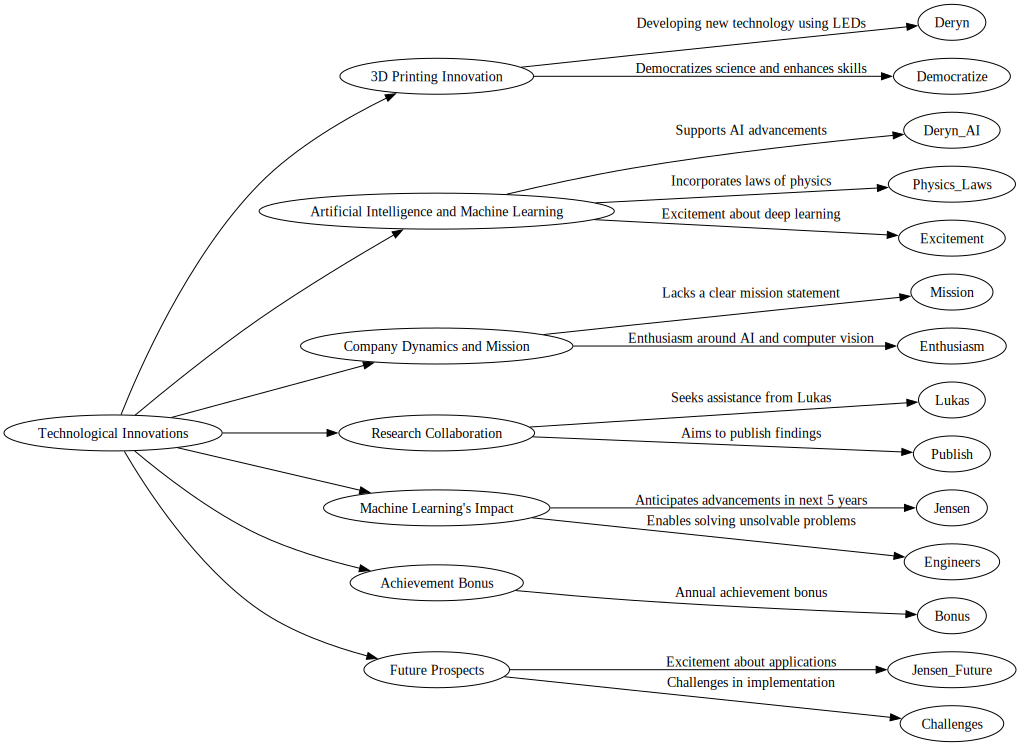

In [15]:
summarize_main()